In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("C:\\Users\\kriti\\Downloads\\archive (12)\\Churn_Modelling.csv")


In [3]:
df.shape

(10000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
def catagorical(df):
    cat_col = df.select_dtypes(include = ["object"]).columns
    num_cols = 3
    num_rows = (len(cat_col)+ num_cols -1)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=( 15, 15))
    fig.suptitle("distribution of catagorical features", fontsize =16)
    axes = axes.flatten()
    for i, col in enumerate(cat_col):
        sns.barplot(
        x=df[col].value_counts().index,
        y=df[col].value_counts().values,
        ax =axes[i],
        )
    axes[i].set_title(f"Distribution of {col}", fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("count", fontsize=12)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    # Adjust layout 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<Figure size 640x480 with 0 Axes>

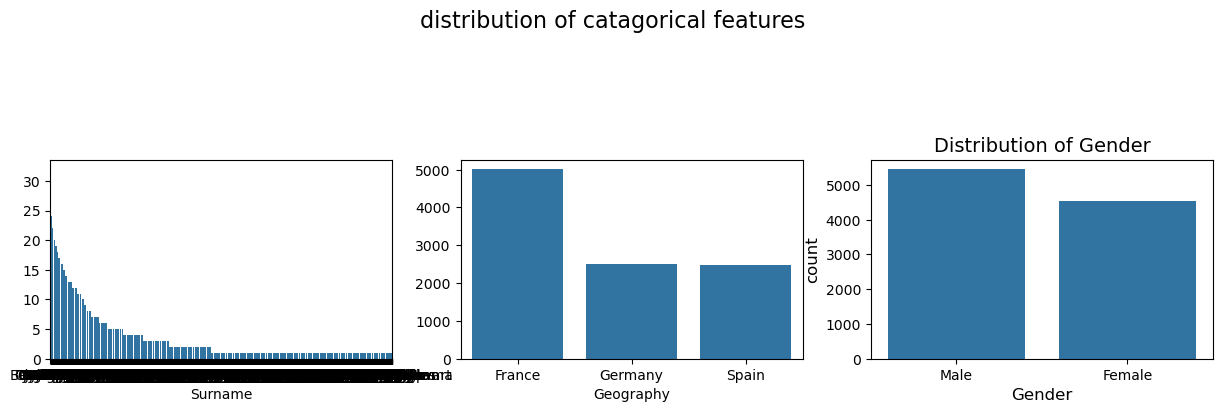

In [7]:
catagorical(df)

In [29]:
def num_dist(df, exclude_columns = ['RowNumber','CustomerId','Exited']):
    numc_cols= df.select_dtypes(include = ['number']).columns
    numc_cols = [col for col in numc_cols if col not in exclude_columns]
    num_cols = 3
    num_rows = (len(numc_cols)+num_cols-1)
    fig,axes = plt.subplots(num_rows, num_cols, figsize=(18,15))
    fig.suptitle("distribution of catagorical features", fontsize =16)
    axes = axes.flatten()
    for i, col in enumerate(numc_cols):
        sns.histplot(df[col], kde=True, ax=axes[i],  element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()

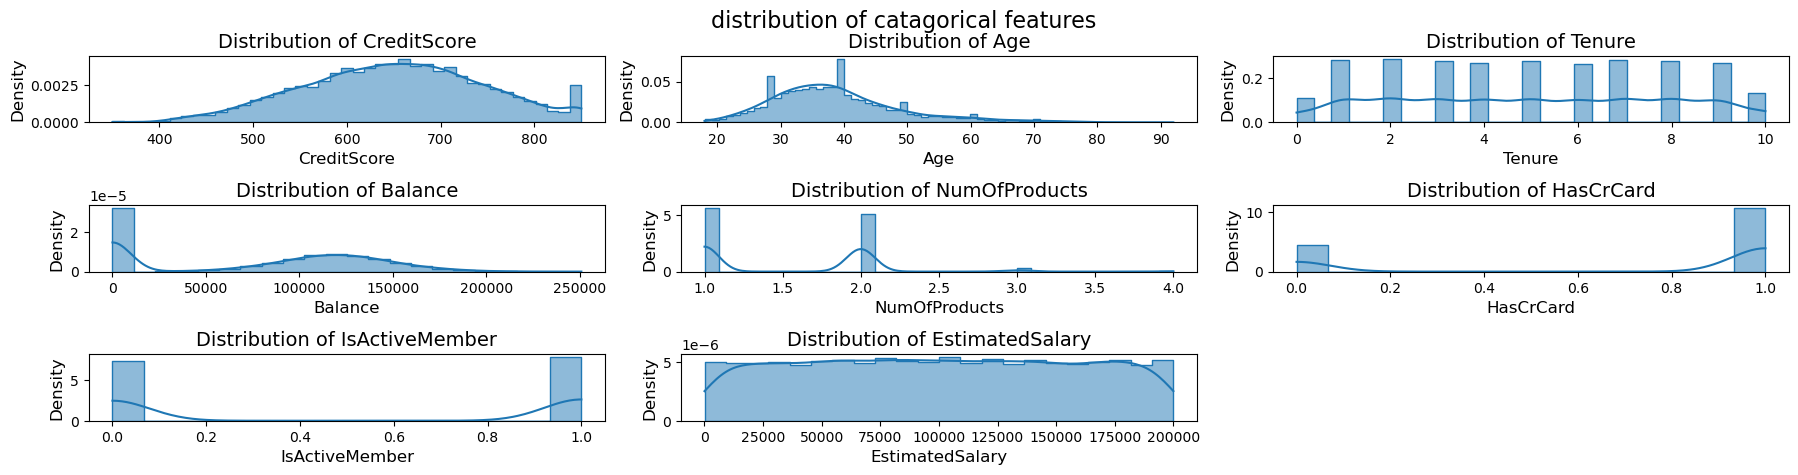

In [31]:
num_dist(df)


In [43]:


class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoder = OneHotEncoder(sparse_output=False)
        self.encoder.fit(X[['Geography']])
        self.column_names = self.encoder.get_feature_names_out(['Geography'])
        return self
    
    def transform(self, X):
        encoded_matrix = pd.DataFrame(self.encoder.transform(X[['Geography']]), columns=self.column_names, index=X.index)
        return pd.concat([X, encoded_matrix], axis=1).drop('Geography', axis=1)

class FeatureLabel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(X['Gender'])
        return self
    
    def transform(self, X):
        X['Gender'] = self.label_encoder.transform(X['Gender'])
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=['RowNumber', 'CustomerId', 'Surname'], errors='ignore')


In [45]:
pipeline = Pipeline([
    ('feature_encoder', FeatureEncoder()),
    ('feature_label', FeatureLabel()),
    ('feature_dropper', FeatureDropper()),
])

In [47]:
train_df = pipeline.fit_transform(df)


In [49]:
train_df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


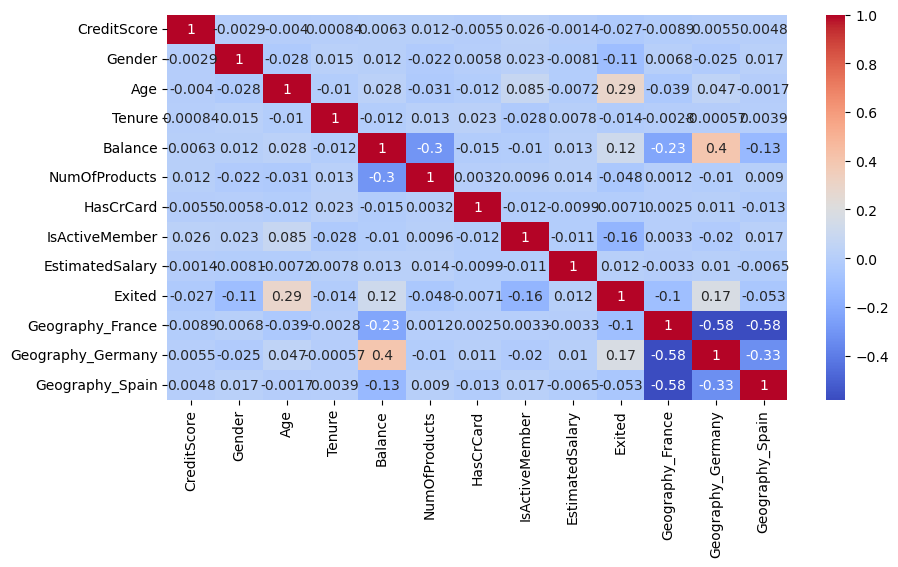

In [53]:
plt.figure(figsize=(10, 5))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')

plt.show()


In [57]:
X = train_df.drop("Exited", axis=1)
y = train_df['Exited']

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Gender             10000 non-null  int32  
 2   Age                10000 non-null  int64  
 3   Tenure             10000 non-null  int64  
 4   Balance            10000 non-null  float64
 5   NumOfProducts      10000 non-null  int64  
 6   HasCrCard          10000 non-null  int64  
 7   IsActiveMember     10000 non-null  int64  
 8   EstimatedSalary    10000 non-null  float64
 9   Geography_France   10000 non-null  float64
 10  Geography_Germany  10000 non-null  float64
 11  Geography_Spain    10000 non-null  float64
dtypes: float64(5), int32(1), int64(6)
memory usage: 898.6 KB


In [63]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Exited
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.3 KB


In [75]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, r2_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVC model
svc_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # You can tune C and gamma for better results
svc_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svc_model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.856
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1607
           1       0.77      0.38      0.51       393

    accuracy                           0.86      2000
   macro avg       0.82      0.68      0.71      2000
weighted avg       0.85      0.86      0.84      2000

